<a href="https://colab.research.google.com/github/ChoiSenn/Study/blob/main/AI/PyTorch/202251509_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch 튜토리얼

<br><br>
***
<br><br>

## 0. 빠른 시작

<br>

### 0-1. 데이터 작업하기

<br>

- torch.utils.data.Dataset : 샘플과 정답(label)을 저장.<br>
- torch.utils.data.DataLoader : Dataset을 순회 가능한 객체(iterable)로 감쌈.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

*PyTorch import*

<br>

- torchvision.datasets : 다양한 실제 비전 데이터에 대한 dataset을 포함.

In [ ]:
# 공개 데이터셋에서 학습 데이터를 내려받음
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받음
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



<br>

Dataset을 DataLoader의 인자로 전달.<br>
이는 데이터셋을 순회 가능한 객체로 감싸고, 자동화된 배치, 샘플링, 섞기 및 다중 프로세스로 데이터 불러오기를 지원.<br>
배치 크기를 64로 정의. 즉, dataloader 객체의 각 요소는 64개의 feature과 label을 묶음(batch)으로 반환.

In [ ]:
batch_size = 64

# 데이터로더를 생성
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


<br><br>
***
<br><br>

### 0-2. 모델 만들기

<br>

PyTorch에서 신경망 모델은 nn.Module을 상속받는 클래스를 생성하여 정의.<br>

\__init__ 함수에서 신경망의 계층들을 정의하고 forward 함수에서 신경망에 데이터를 어떻게 전달할지 지정.

In [ ]:
# 학습에 사용할 CPU나 GPU 장치를 얻음
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


<br><br>
***
<br><br>

### 0-3. 모델 매개변수 최적화하기

<br>

모델을 학습하려면 손실 함수와 옵티마이저가 필요.<br>

각 학습 단계에서 모델은 학습 데이터셋에 대한 예측을 수행하고, 예측 오류를 역전파하여 모델의 매개변수를 조정.

In [ ]:
loss_fn = nn.CrossEntropyLoss()  # 손실 함수
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # 옵티마이저

def train(dataloader, model, loss_fn, optimizer):  # 매개변수 조정
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):  # 모델이 학습하고 있는지를 확인하기 위해 테스트 데이터셋으로 모델 성능 확인
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 5  # 학습 단계는 여러번의 반복 단계(epochs)를 거쳐서 수행.
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303845  [    0/60000]
loss: 2.288065  [ 6400/60000]
loss: 2.271035  [12800/60000]
loss: 2.271909  [19200/60000]
loss: 2.245782  [25600/60000]
loss: 2.226938  [32000/60000]
loss: 2.230858  [38400/60000]
loss: 2.192619  [44800/60000]
loss: 2.197311  [51200/60000]
loss: 2.171274  [57600/60000]
Test Error: 
 Accuracy: 46.5%, Avg loss: 2.159373 

Epoch 2
-------------------------------
loss: 2.172802  [    0/60000]
loss: 2.159808  [ 6400/60000]
loss: 2.102120  [12800/60000]
loss: 2.121076  [19200/60000]
loss: 2.071763  [25600/60000]
loss: 2.011209  [32000/60000]
loss: 2.041390  [38400/60000]
loss: 1.957286  [44800/60000]
loss: 1.968925  [51200/60000]
loss: 1.901557  [57600/60000]
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.896068 

Epoch 3
-------------------------------
loss: 1.933134  [    0/60000]
loss: 1.899467  [ 6400/60000]
loss: 1.784704  [12800/60000]
loss: 1.823880  [19200/60000]
loss: 1.721092  [25600/60000]
loss: 1.672656  [32000/600

<br><br>
***
<br><br>

### 0-4. 모델 저장하기

<br>

모델을 저장하는 일반적일 방법은  모델의 매개변수를 포함하여 내부 상태 사전을 직렬화하는 것.

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


<br><br>
***
<br><br>

### 0-5. 모델 불러오기

<br>

모델을 불러오는 과정에는 모델 구조를 다시 만들고 상태 사전을 모델에 불러오는 과정이 포함.

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Bag", Actual: "Ankle boot"


<br><br>
***
<br><br>

## 1. 텐서 (TENSOR)
<br>

### 1-1. 텐서 초기화

<br>

텐서는 배열이나 행렬과 매우 유사한 특수 자료구조.<br>
PyTorch에서는 텐서를 사용하여 모델의 입출력, 그리고 모델의 매개변수들을 부호화함.

<br>

텐서는 GPU나 다른 하드웨어 가속기에서 실행할 수 있다는 점만 제외하면 numpy의 ndarray와 유사.

In [7]:
import torch  # import 
import numpy as np

data = [[1, 2],[3, 4]]  # 데이터로부터 직접 생성
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)  # numpy 배열로부터 생성

# 다른 텐서로부터 생성
x_ones = torch.ones_like(x_data) # x_data의 속성을 유지
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # x_data의 속성을 덮어씀
print(f"Random Tensor: \n {x_rand} \n")

# 무작위, 혹은 상수 값 사용
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.3198, 0.8919],
        [0.2416, 0.6615]]) 

Random Tensor: 
 tensor([[0.5068, 0.3466, 0.1152],
        [0.1503, 0.8432, 0.2261]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


<br><br>
***
<br><br>

### 1-2. 텐서의 속성 (Attribute)

<br>

텐서의 속성은 텐서의 모양, 자료형 및 어느 장치에 저장되는지를 나타냄.

In [8]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


<br><br>
***
<br><br>

### 1-3. 텐서의 연산 (Operation)

<br>

전치, 인덱싱, 슬라이싱, 수학 계산, 선형 대수, 임의 샘플링 등, 100가지 이상의 텐서 연산이 가능.<br>

기본적으로 텐서는 CPU에 생성.<br> 
.to 메소드를 사용하면 GPU로 텐서를 명시적으로 이동 가능.

In [9]:
# GPU가 존재하면 텐서를 이동
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

In [10]:
# numpy 식 표준 인덱싱과 슬라이싱
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [11]:
# 텐서 합치기
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [12]:
# 산술 연산

# 두 텐서 간의 행렬 곱(matrix multiplication)을 계산. y1, y2, y3은 모두 같은 값을 가짐
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# 요소별 곱(element-wise product)을 계산. z1, z2, z3는 모두 같은 값을 가짐
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [ ]:
# 단일 요소 텐서
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [ ]:
# 바꿔치기 연산    !! 메모리를 절약할 수 있지만 기록이 즉시 삭제되어 도함수 계산에 문제 발생 위험 있음
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


<br><br>
***
<br><br>

### 1-4. Numpy 변환 (Bridge)

<br>

CPU 상의 텐서와 numpy 배열은 메모리 공간을 공유하기 때문에, 하나를 변경하면 다른 하나도 변경 됨.

In [13]:
# 텐서를 numpy 배열로 변환
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t.add_(1)
print(f"t: {t}")
print(f"n: {n}")  # 텐서의 변경사항이 numpy 배열에도 반영

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]
t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [14]:
# numpy 배열을 텐서로 변환
n = np.ones(5)
t = torch.from_numpy(n)

np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


<br><br>
***
<br><br>

## 2. Dataset과 Dataloader
<br>

### 2-1. 데이터셋 불러오기

<br>

다음 매개변수들을 이용하여 FashionMNIST 데이터셋을 불러옴
- root : 학습/테스트 데이터가 저장되는 경로
- train : 학습용 또는 테스트용 데이터셋 여부를 지정
- download=True : root에 데이터가 없는 경우 인터넷에서 다운로드
- transform, target_transform : feature과 label transform을 지정

In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

<br><br>
***
<br><br>

### 2-2. 데이터셋을 순회하고 시각화하기

<br>

Dataset에 리스트처럼 직접 접근 가능.

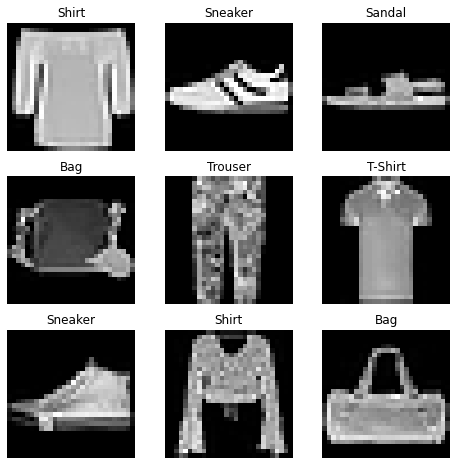

In [16]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

<br><br>
***
<br><br>

### 2-2. 데이터셋을 순회하고 시각화하기

<br>

사용자 정의 Dataset 클래스는 반드시 init, len, getitem이라는 3개의 함수를 구현해야 함.
<br>

FashionMNIT의 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file CSV 파일에 별도로 저장.

In [17]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

\_\_init__ : dataset 객체가 생성 될 때 한 번만 실행.

\_\_len__ : 데이터셋의 샘플 개수를 반환.

\_\_getitem__ : 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환. 인덱스를 기반으로, 디스크에서 이미지 위치를 식별하고, read_image를 사용하여 이미지를 텐서로 변환하고, self.img_labels의 csv 데이터로부터 해당하는 label을 가져오고, 변형 함수들을 호출한 뒤, 텐서 이미지와 라벨을 python 사전형으로 반환.

<br><br>
***
<br><br>

### 2-3. DataLoader로 학습용 데이터 준비하기

<br>

dataset은 데이터셋의 feature를 가져오고 하나의 샘플에 label을 지정하는 일을 한 번에 함.

모델을 학습할 때, 일반적으로 샘플들을 "미니배치(minibatch)"로 전달하고, 매 에폭마다 데이터를 다시 섞어서 과적합을 막고, python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려 함.

DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체.

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

<br><br>
***
<br><br>

### 2-4. DataLoader를 통해 순회하기 (iterate)

<br>

dataloader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회할 수 있음. 각 순회는 train_features와 train_labels의 묶음을 반환. shuffle_True로 지정했으므로, 모든 배치를 순회한 뒤, 데이터가 섞임.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


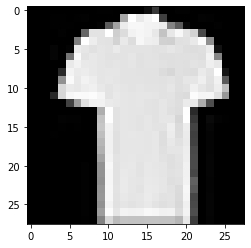

Label: 0


In [ ]:
# 이미지와 정답(label)을 표시
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

<br><br>
***
<br><br>

## 3. 변형 (Transform)
<br>

### 3-1. 변형

<br>

데이터가 항상 머신러닝 알고리즘 학습에 필요한 형태로 제공되지는 않음.

변형을 통해 데이터를 조작하고 학습에 적합하게 만들어야 함.


FashionMNIST feature은 PIL Image 형식이며, label은 정수 형태.

학습을 하려면 정규화 된 텐서 형태의 feature과 원-핫으로 부호화 된 텐서 형태의 label이 필요. 변형을 위해 ToTensor와 Lambda를 사용.

In [2]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw




- ToTensor() : PIL Image나 Numpy ndarray를 FloatTensor로 변환하고, 이미지의 픽셀의 크기 값을 [0., 1.] 범위로 비례하여 조정함.

- Lambda 변형 : 사용자 정의 람다 함수를 적용. 정수를 원-핫으로 부호화된 텐서로 바꾸는 함수를 정의. 이 함수는 먼저 데이터셋 정답의 개수 크기인 영 텐서를 만들고, scatter_를 호출하여 주어진 정답 y에 해당하는 인덱스에 value=1을 할당.

In [3]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

<br><br>
***
<br><br>

## 4. 신경망 모델 구성하기
<br>

### 4-1. 학습을 위한 장치 얻기

<br>

신경망은 데이터에 대한 연산을 수행하는 계층과 모듈로 구성.

torch.cuda를 사용하여 GPU 하드웨어 가속기에서 모델 학습이 가능.

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


<br><br>
***
<br><br>

### 4-2. 클래스 정의하기

<br>

신경망 모델을 nn.Model의 하위클래스로 정의하고, \__init__에서 신경망 계층들을 초기화 함.

nn.Module을 상속받은 모든 클래스는 forward 메소드에 입력 데이터에 대한 연산들을 구현.

In [22]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# NeuralNetwork의 인스턴스를 생성하고 이를 device로 이동한 뒤, 구조를 출력
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)



모델을 사용하기 위해 입력 데이터를 전달.

모델에 입력을 호출하면 각 분류에 대한 raw 예측값이 있는 10-차원 텐서가 반환. 원시 예측값을 nn.Softmax 모듈의 인스턴스에 통과시켜 예측 확률을 얻음.

In [23]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([9])


<br><br>
***
<br><br>

### 4-3. 모델 계층 (Layer)

<br>

아래 코드는 28x28 크기의 이미지 3개로 구성된 미니배치를 가져와, 신경망을 통과할 때 어떤 일이 발생하는지 알아보는 모습.

In [25]:
input_image = torch.rand(3,28,28)
print(input_image.size())

# nn.Flatten : 계층을 초기화하여 각 28x28의 2D 이미지를 784 픽셀 값을 갖는 연속된 배열로 변환
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

# nn.Linear : 저장된 가중치와 편향을 사용하여 입력에 선형 변환을 적용하는 모듈
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

# nn.ReLU : 비선형 활성화는 모델의 입력과 출력 사이에 복잡한 관계를 만듦.
#           선형 변환 후에 적용되어 비선형성을 도입하고, 신경망이 다양한 현상을 학습할 수 있도록 도움.
#           이 모델에서는 nn.ReLU를 선형 계층들 사이에 사용하지만, 모델을 만들 때에는 비선형성을 가진 다른 활성화를 도입할 수도 있음.
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

# nn.Sequential : 순서를 갖는 모듈의 컨테이너. 데이터는 정의된 것과 같은 순서로 모든 모듈들을 통해 전달됨.
#                 순차 컨테이너를 사용하여 아래의 seq_modules와 같은 신경망을 빠르게 만들 수 있음.
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

# nn.Softmax : 신경망의 마지막 선형 계층은 nn.Softmax 모듈에 전달된 logits를 반환.
#              logits는 모델의 각 분류에 대한 예측 확률을 나타내도록 [0. 1] 범위로 비례하여 조정됨.
#              dim 매개변수는 값의 합이 1이 되는 차원을 나타냄.
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

torch.Size([3, 28, 28])
torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU: tensor([[ 0.4157,  0.0703,  0.3258, -0.4988,  0.2926, -0.1186,  0.0273,  0.2084,
          0.3332, -0.2617, -0.4446,  0.3394,  0.3097,  0.1454,  0.3253,  0.1142,
          0.0184, -0.3575, -0.1090,  0.1061],
        [ 0.4628,  0.1834,  0.7685, -0.4283,  0.1444,  0.0799,  0.1514,  0.5340,
          0.2530, -0.2549, -0.6058,  0.2123,  0.3305, -0.0066,  0.3459,  0.0227,
         -0.2269, -0.2308, -0.2190,  0.2295],
        [ 0.7466,  0.3608,  0.7033, -0.5642,  0.2514,  0.2426,  0.4409,  0.2258,
          0.4045, -0.0073, -0.2715,  0.0599,  0.2959, -0.0181,  0.2264,  0.3996,
          0.1589, -0.4392, -0.0993,  0.1354]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.4157, 0.0703, 0.3258, 0.0000, 0.2926, 0.0000, 0.0273, 0.2084, 0.3332,
         0.0000, 0.0000, 0.3394, 0.3097, 0.1454, 0.3253, 0.1142, 0.0184, 0.0000,
         0.0000, 0.1061],
        [0.4628, 0.1834, 0.7685, 0.0000, 0.1444, 0.0799, 0.1514, 0.53

<br><br>
***
<br><br>

### 4-4. 모델 매개변수

<br>

신경망 내부의 많은 계층들은 매개변수화 됨. 즉, 학습 중에 최적화 되는 가중치와 편향과 연관지어짐.

nn.Module을 상속하면 모델 객체 내부의 모든 필드들이 자동으로 추적되며, 모델의 parameters() 및 named_parameters() 메소드로 모든 매개변수에 접근할 수 있게 됨.

In [26]:
# 각 매개변수들을 순회하며, 매개변수의 크기와 값을 출력.
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0001, -0.0169, -0.0211,  ...,  0.0202,  0.0340, -0.0053],
        [-0.0308, -0.0277,  0.0217,  ...,  0.0284, -0.0229,  0.0249]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0159, 0.0184], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0043,  0.0127, -0.0042,  ...,  0.0348, -0.0329, -0.0220],
        [ 0.0032,  0.0122,  0.0080,  ..., -0.0296, -0.0255, -0.0337]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Si

<br><br>
***
<br><br>

## 5. Autograd
<br>

### 5-1. TORCH.AUTOGRAD를 사용한 자동 미분

<br>

신경망 학습 시에 가장 자주 사용되는 알고리즘은 역전파. 역전파 알고리즘에서 매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 변화도에 따라 조정됨.

변화도를 계산하기 위해 pytorch의 torch.autograd라는 자동 미분 엔진을 이용. 이는 모든 계산 그래프에 대한 변화도의 자동 계산을 지원.

입력 x, 매개변수 w와 b, 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층 신경망을 가정하였을 때 다음과 같이 정의.

In [27]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

<br><br>
***
<br><br>

### 5-2. Tensor, Function과 연산그래프(Computational graph)

<br>

위의 신경망에서 w와 b는 최적화를 해야 하는 매개변수. 따라서 이러한 변수들에 대한 손실 함수의 변화도를 계산해야 함. 이를 위해 해당 텐서에 requires_grad 속성을 설정.

연산 그래프 구성을 위해 텐서에 적용하는 함수는 사실 function 클래스의 객체. 이 객체는 순전파 방향으로 함수를 계산하는 방법과, 역방향 전파 단계에서 도함수를 계산하는 방법을 알고 있음.

역방향 전파 함수에 대한 참조는 텐서의 grad_fn 속성에 저장.

In [28]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f54bb071dd0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f54bb0715d0>


<br><br>
***
<br><br>

### 5-3. 변화도(Gradient) 계산하기

<br>

신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를 계산해야 함.

이러한 도함수를 계산하기 위해, loss.backward() 를 호출한 다음 w.grad와 b.grad에서 값을 가져옴.

In [29]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1780, 0.3330, 0.3307],
        [0.1780, 0.3330, 0.3307],
        [0.1780, 0.3330, 0.3307],
        [0.1780, 0.3330, 0.3307],
        [0.1780, 0.3330, 0.3307]])
tensor([0.1780, 0.3330, 0.3307])


<br><br>
***
<br><br>

### 5-4. 변화도 추적 멈추기

<br>

기본적으로, requires_grad=True인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을 지원. 그러나 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 순전파 연산만 필요한 경우에는, 이러한 추적이나 지원이 필요 없을 수 있음.

 연산 코드를 torch.no_grad() 블록으로 둘러싸서 연산 추적을 멈출 수 있음.

In [30]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [31]:
# 혹은 detach() 메소드 사용

z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


변화도 추적을 멈춰야 하는 이유

- 신경망의 일부 매개변수를 고정된 매개변수(frozen parameter)로 표시. 이는 사전 학습된 신경망을 미세조정 할 때 매우 일반적인 시나리오임.

- 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때 연산 속도가 향상.

<br><br>
***
<br><br>

### 5-5. 연산 그래프에 대한 추가 정보

<br>

방향성 비순환 그래프를 뿌리에서부터 잎까지 추적하면 연쇄 법칙(chain rule)에 따라 변화도를 자동으로 계산할 수 있음.

순전파 단계에서, autograd는 다음 두 가지 작업을 동시에 수행

- 요청된 연산을 수행하여 결과 텐서를 계산

- DAG에 연산의 변화도 기능(gradient function) 를 유지(maintain)

역전파 단계는 DAG 뿌리(root)에서 .backward() 가 호출될 때 시작. 이 때 autograd는

- 각 .grad_fn 으로부터 변화도를 계산

- 각 텐서의 .grad 속성에 계산 결과를 쌓고(accumulate)

- 연쇄 법칙을 사용하여, 모든 잎(leaf) 텐서들까지 전파(propagate)

<br><br>
***
<br><br>

### 5-6. 텐서 변화도와 야코비안 곱 (Jacobian Product)

<br>

대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산해야 합니다. 그러나 출력 함수가 임의의 텐서인 경우가 있습니다. 이럴 때, PyTorch는 실제 변화도가 아닌 야코비안 곱(Jacobian product)을 계산.

동일한 인자로 backward를 두차례 호출하면 변화도 값이 달라짐. 이는 역방향 전파를 수행할 때, PyTorch가 변화도를 누적(accumulate)해주기 때문. 즉, 계산된 변화도의 값이 연산 그래프의 모든 잎(leaf) 노드의 grad 속성에 추가 됨. 따라서 제대로 된 변화도를 계산하기 위해서는 grad 속성을 먼저 0으로 만들어야 함. 실제 학습 과정에서는 옵티마이저(optimizer)가 이 과정을 도와줌.

In [32]:
inp = torch.eye(5, requires_grad=True)
out = (inp+1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


<br><br>
***
<br><br>

## 6. 최적화
<br>

### 6-1. 모델 매개변수 최적화 기본 코드

<br>

모델과 데이터가 준비되었으면, 데이터에 매개변수를 최적화하여 모델을 학습하고, 검증하고, 테스트.

모델을 학습하는 과정은 반복적인 과정을 거침. (에폭(epoch)이라고 부르는) 각 반복 단계에서 모델은 출력을 추측하고, 추측과 정답 사이의 오류(손실(loss))를 계산하고, 매개변수에 대한 오류의 도함수(derivative)를 수집한 뒤, 경사하강법을 사용하여 이 파라미터들을 최적화(optimize).

In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

<br><br>
***
<br><br>

### 6-2. 하이퍼파라미터(Hyperparameter)

<br>

하이퍼파라미터는 모델 최적화 과정을 제어할 수 있는 조절 가능한 매개변수.

- 에폭(epoch) 수 : 데이터셋을 반복하는 횟수

- 배치 크기(batch size) : 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수

- 학습률(learning rate) : 각 배치/에폭에서 모델의 매개변수를 조절하는 비율. 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있음.

In [34]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

<br><br>
***
<br><br>

### 6-3. 최적화 단계(Optimization Loop)

<br>

하이퍼파라미터를 설정한 뒤에는 최적화 단계를 통해 모델을 학습하고 최적화할 수 있음. 최적화 단계의 각 반복(iteration)을 에폭이라고 부름.

- 학습 단계(train loop) : 학습용 데이터셋을 반복(iterate)하고 최적의 매개변수로 수렴.
- 검증/테스트 단계(validation/test loop) : 모델 성능이 개선되고 있는지를 확인하기 위해 테스트 데이터셋을 반복(iterate).

In [35]:
# 손실 함수(loss function) : 획득한 결과와 실제 값 사이의 틀린 정도(degree of dissimilarity)를 측정하며, 학습 중에 이 값을 최소화.
#                            주어진 데이터 샘플을 입력으로 계산한 예측과 정답(label)을 비교하여 손실(loss)을 계산.
#                            모델의 출력 로짓(logit)을 nn.CrossEntropyLoss에 전달하여 로짓(logit)을 정규화하고 예측 오류를 계산
loss_fn = nn.CrossEntropyLoss()  # 손실함수 초기화

# 옵티마이저(Optimizer) : 최적화 알고리즘은 이 과정이 수행되는 방식(여기에서는 확률적 경사하강법(SGD; Stochastic Gradient Descent))을 정의.
#                         모든 최적화 절차(logic)는 optimizer 객체에 캡슐화(encapsulate)됨.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # 학습하려는 모델의 매개변수와 학습률(learning rate) 하이퍼파라미터를 등록하여 옵티마이저를 초기화

학습 단계(loop)에서의 최적화

- optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정. 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정.

- loss.backwards()를 호출하여 예측 손실(prediction loss)을 역전파 함. PyTorch는 각 매개변수에 대한 손실의 변화도를 저장.

- 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정.

<br><br>
***
<br><br>

### 6-4. 전체 구현

<br>

최적화 코드를 반복하여 수행하는 train_loop와 테스트 데이터로 모델의 성능을 측정하는 test_loop를 정의.

In [36]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

손실 함수와 옵티마이저를 초기화하고 train_loop와 test_loop에 전달. 모델의 성능 향상을 알아보기 위해 자유롭게 에폭(epoch) 수를 증가시켜 볼 수 있음.

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299956  [    0/60000]
loss: 2.289841  [ 6400/60000]
loss: 2.268665  [12800/60000]
loss: 2.268254  [19200/60000]
loss: 2.244914  [25600/60000]
loss: 2.214882  [32000/60000]
loss: 2.232005  [38400/60000]
loss: 2.196493  [44800/60000]
loss: 2.185657  [51200/60000]
loss: 2.166306  [57600/60000]
Test Error: 
 Accuracy: 45.1%, Avg loss: 2.153752 

Epoch 2
-------------------------------
loss: 2.161937  [    0/60000]
loss: 2.156305  [ 6400/60000]
loss: 2.094841  [12800/60000]
loss: 2.115325  [19200/60000]
loss: 2.063938  [25600/60000]
loss: 2.003325  [32000/60000]
loss: 2.043811  [38400/60000]
loss: 1.959506  [44800/60000]
loss: 1.963623  [51200/60000]
loss: 1.905825  [57600/60000]
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.895353 

Epoch 3
-------------------------------
loss: 1.925070  [    0/60000]
loss: 1.905435  [ 6400/60000]
loss: 1.780995  [12800/60000]
loss: 1.829861  [19200/60000]
loss: 1.714953  [25600/60000]
loss: 1.668037  [32000/600

<br><br>
***
<br><br>

## 7. 모델 저장하고 불러오기
<br>

### 7-1. 모델 가중치 저장하고 불러오기

<br>

PyTorch 모델은 학습한 매개변수를 state_dict라고 불리는 내부 상태 사전(internal state dictionary)에 저장. 이 상태 값들은 torch.save 메소드를 사용하여 저장(persist)할 수 있음.

In [38]:
import torch
import torchvision.models as models

model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

모델 가중치를 불러오기 위해서는, 먼저 동일한 모델의 인스턴스(instance)를 생성한 다음에 load_state_dict() 메소드를 사용하여 매개변수들을 불러옴.

In [39]:
model = models.vgg16() # 기본 가중치를 불러오지 않으므로 pretrained=True를 지정하지 않습니다.
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<br><br>
***
<br><br>

### 7-2. 모델의 형태를 포함하여 저장하고 불러오기

<br>

In [40]:
torch.save(model, 'model.pth')  # 클래스의 구조를 모델과 함께 저장
model = torch.load('model.pth')  # 모델 불러옴